In [1]:
import tensorflow as tf
import keras 
from keras import backend as K
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Activation,Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.applications.inception_v3 import preprocess_input
from keras.utils import to_categorical

from skimage import color, filters, exposure, morphology

from sklearn.metrics import confusion_matrix

import os
import glob

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_path = '../data/MESSIDOR_images/filtered/train'
val_path = '../data/MESSIDOR_images/filtered/val'
test_path = '../data/MESSIDOR_images/filtered/test'

In [3]:
train_batches = ImageDataGenerator(rescale=1./255)\
    .flow_from_directory(directory=train_path, target_size=(224, 224), color_mode='rgb', classes=['NoDR','DR'],
                         batch_size=len(glob.glob(train_path+'/*/*')), seed=9)

test_batches = ImageDataGenerator(rescale=1./255)\
    .flow_from_directory(directory=test_path, target_size=(224, 224), color_mode='rgb', classes=['NoDR','DR'],
                         batch_size=len(glob.glob(test_path+'/*/*')), seed=9)

val_batches = ImageDataGenerator(rescale=1./255)\
    .flow_from_directory(directory=val_path, target_size=(224, 224), color_mode='rgb', classes=['NoDR','DR'],
                         batch_size=len(glob.glob(val_path+'/*/*')), seed=9)

Found 829 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


In [4]:
train_image, train_label = next(train_batches)
test_image, test_label = next(test_batches)
val_image, val_label = next(val_batches)

In [5]:
print(len(train_label))
print(len(test_label))
print(len(val_label))

829
106
103


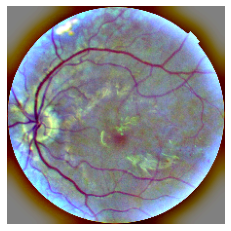

In [6]:
plt.imshow(train_image[0])
plt.axis('off')
plt.show()

In [7]:
def display_plot(images_array, label):
    fig, axes = plt.subplots(1, 5, figsize=(25,25))
    axes = axes.flatten()  
    indexer = 0
    for image, ax in zip(images_array, axes):
        ax.set_title(label[indexer])
        indexer+=1
        ax.imshow(image)
        ax.axis('off')

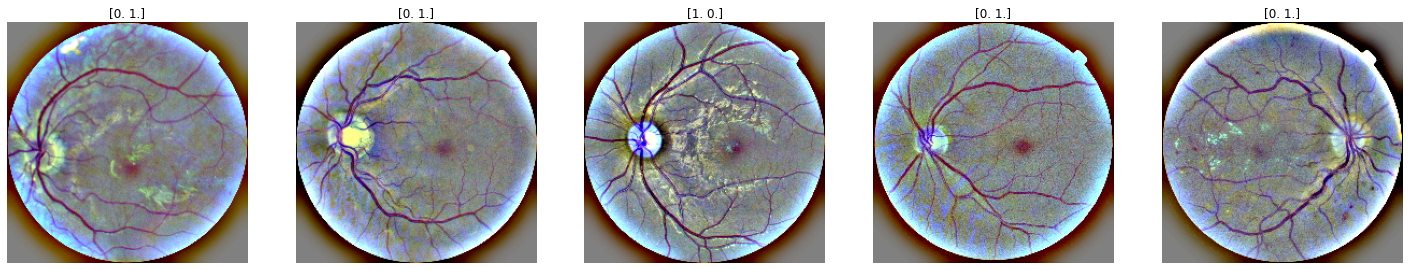

In [8]:
display_plot(train_image, train_label)
plt.savefig('../figures/preprocessed_images')

# Model Construction

In [9]:
num_classes = 2

In [10]:
cnn = Sequential()

In [11]:
cnn.add(Conv2D(32, kernel_size=(3,3), input_shape=(224,224,3),activation='relu'))

In [12]:
cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))

In [13]:
#cnn.add(Dropout(rate=0.2))

In [14]:
cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))

In [15]:
cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))

In [16]:
#cnn.add(Dropout(rate=0.2))

In [17]:
#cnn.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))

In [18]:
#cnn.add(Dropout(rate=0.2))

In [19]:
cnn.add(Flatten())

In [20]:
cnn.add(Dense(num_classes ,activation='softmax'))

In [21]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 387202    
Total params: 406,594
Trainable params: 406,594
Non-trainable params: 0
__________________________________________________

In [23]:
cnn.fit(train_image,
        train_label,
        epochs=30,
        verbose=1,
        shuffle=True,
        validation_data=(val_image,val_label))

Epoch 1/30
26/26 [==============================] - 30s 1s/step - loss: 1.3729 - accuracy: 0.5151 - val_loss: 0.6899 - val_accuracy: 0.5243
Epoch 2/30
26/26 [==============================] - 31s 1s/step - loss: 0.6918 - accuracy: 0.5271 - val_loss: 0.6900 - val_accuracy: 0.5243
Epoch 3/30
26/26 [==============================] - 32s 1s/step - loss: 0.6899 - accuracy: 0.5271 - val_loss: 0.6854 - val_accuracy: 0.5243
Epoch 4/30
26/26 [==============================] - 34s 1s/step - loss: 0.6815 - accuracy: 0.5597 - val_loss: 0.6652 - val_accuracy: 0.6796
Epoch 5/30
26/26 [==============================] - 33s 1s/step - loss: 0.6656 - accuracy: 0.5923 - val_loss: 0.6446 - val_accuracy: 0.6893
Epoch 6/30
26/26 [==============================] - 28s 1s/step - loss: 0.6338 - accuracy: 0.6417 - val_loss: 0.6943 - val_accuracy: 0.6214
Epoch 7/30
26/26 [==============================] - 28s 1s/step - loss: 0.6242 - accuracy: 0.6550 - val_loss: 0.6444 - val_accuracy: 0.6699
Epoch 8/30
26/26 [==

In [24]:
cnn.save('../models/cnn1_filter')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/cnn1_filter/assets


In [27]:
y_pred = cnn.predict(test_image)
y_pred

array([[3.1039596e-01, 6.8960404e-01],
       [9.9844956e-01, 1.5504506e-03],
       [9.9987686e-01, 1.2313740e-04],
       [9.8853534e-01, 1.1464630e-02],
       [9.9762625e-01, 2.3737452e-03],
       [6.9914973e-01, 3.0085033e-01],
       [7.9286700e-01, 2.0713300e-01],
       [8.3185679e-01, 1.6814320e-01],
       [1.7649537e-01, 8.2350469e-01],
       [6.6123396e-02, 9.3387657e-01],
       [9.9933892e-01, 6.6099747e-04],
       [9.1802663e-01, 8.1973329e-02],
       [4.1085771e-01, 5.8914226e-01],
       [3.4381822e-03, 9.9656183e-01],
       [7.9326034e-02, 9.2067391e-01],
       [4.1560601e-03, 9.9584395e-01],
       [9.6149939e-01, 3.8500637e-02],
       [2.1381658e-01, 7.8618336e-01],
       [9.6295530e-01, 3.7044737e-02],
       [5.7830590e-01, 4.2169413e-01],
       [1.9389436e-01, 8.0610567e-01],
       [8.0982178e-01, 1.9017820e-01],
       [8.3764368e-01, 1.6235635e-01],
       [1.4674509e-01, 8.5325497e-01],
       [4.4827798e-01, 5.5172205e-01],
       [6.5494873e-02, 9.

In [28]:
cnn.evaluate(test_image, test_label)

4/4 [==============================] - 1s 208ms/step - loss: 0.9196 - accuracy: 0.6698


[0.9195607900619507, 0.6698113083839417]

In [29]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [30]:
train_batches.classes.sum() / len(train_batches.classes)

0.47285886610373945

In [31]:
test_batches.classes.sum() / len(test_batches.classes)

0.4716981132075472

In [32]:
val_batches.classes.sum() / len(val_batches.classes)

0.47572815533980584

In [36]:
test_batches.class_indices

{'NoDR': 0, 'DR': 1}

In [33]:
predictions = cnn.predict(x=test_batches)
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [37]:
cf_matrix = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

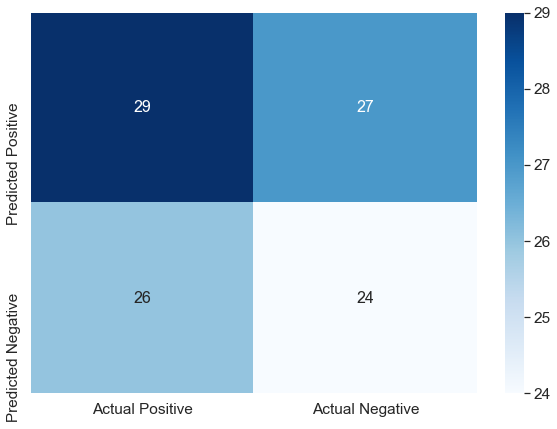

In [38]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='.4g',
            xticklabels=['Actual Positive', 'Actual Negative'], 
            yticklabels=['Predicted Positive', 'Predicted Negative'])

plt.savefig('../figures/modelcm.png')